# ASL Multi-class classification

This notebook tries to replicate the results of office for a larger dataset.

# Step 1: Pre-train the model on 150K images from PASS using SimCLR style training

## Import the necessary modules and define some helper functions

In [2]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define Training Configurations (args)

In [3]:
class Config:
    def __init__(self):
        self.dataset_name = "pass"
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 512
        self.validation_split = 0.0
        self.log_prefix = "SSL"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/PASS_dataset/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':15, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()
conf.is_classification = False

## Set up the logger

In [4]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/SSL___2022.07.08-153522/SSL___2022.07.08-153522.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7fa4fa6749d0>
num_classes=0
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 15, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and visualize the dataset
* Each sample is a pair of augmented images

../Datasets/PASS_dataset/train


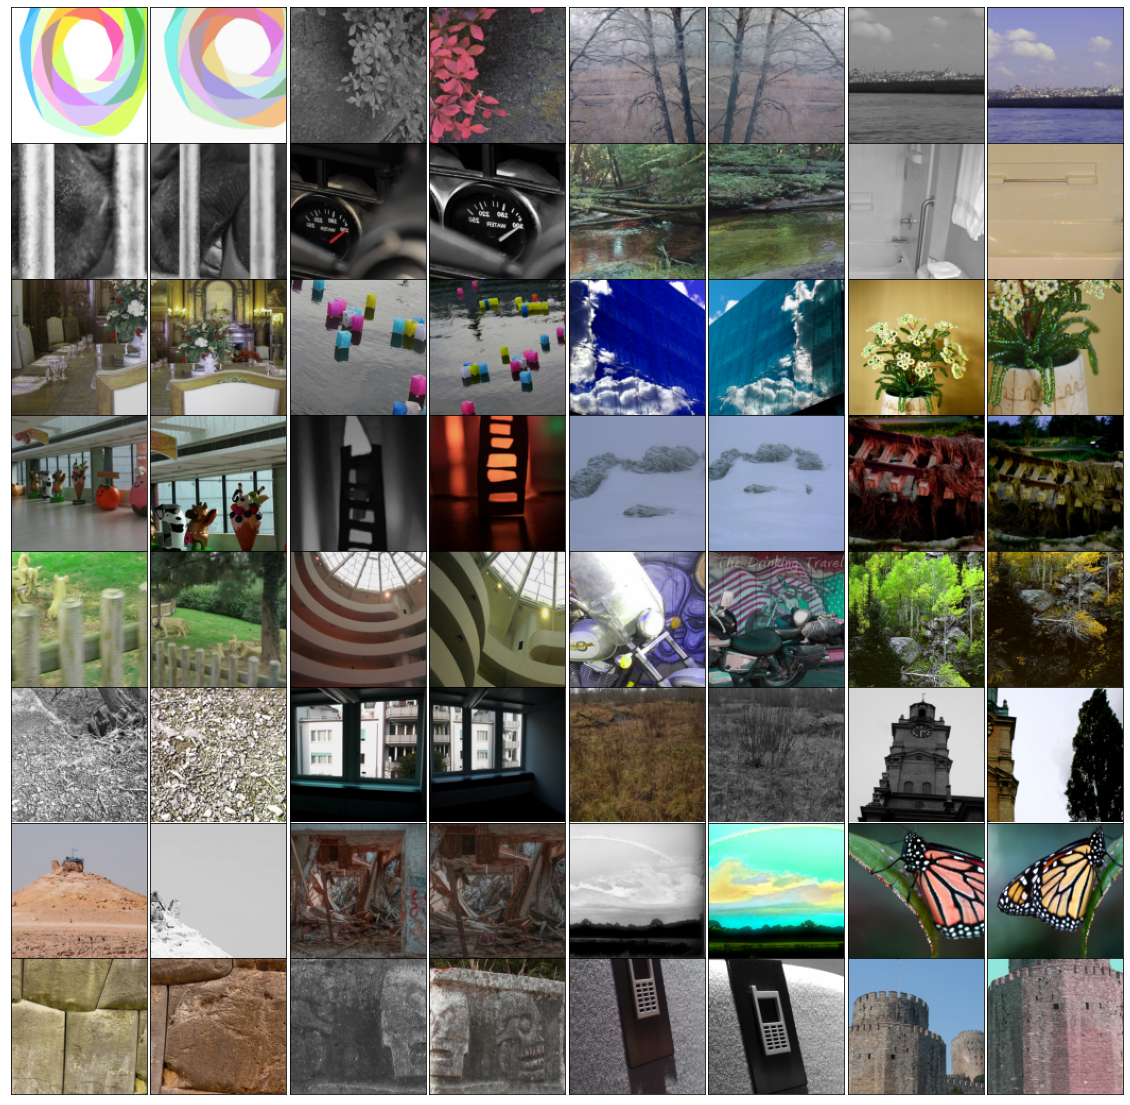

In [5]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

## Create the data loaders

In [6]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=149999
	validation=1
	test=1
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/PASS_dataset/train
../Datasets/PASS_dataset/test


## Set up the device, cuda or cpu

In [7]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model for training

In [ ]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ClassifierBackbone()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

## Set up optimizer, loss, and learning schedule

In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss

In [10]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[15, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({15: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function
* this generalizes the way we do a forward pass so we can reuse the training/validation functions for different models

In [11]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = classifier_forward

## Validation Function

In [1]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    try:
        # iterate over the batches in the validation set
        for validation_step, batch in enumerate(data_loader):
            with torch.no_grad():

                output, target = conf.forward(model, batch, conf)

                # compute loss
                loss = conf.criterion(output, target)

                # measure accuracy and record loss
                losses['objective_loss'].add(loss.item())
                classerr.add(output.data, target)
                confusion.add(output.data, target)

                # store prediction stats
                steps_completed = (validation_step+1)
                if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                    class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                    _, class_preds_batch = torch.max(output, 1)
                    class_probs.append(class_probs_batch)
                    class_preds.append(class_preds_batch)

                    stats = (
                        '',
                        OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                    )
                    if conf.num_classes > 5:
                        stats[1]['Top5'] = classerr.value(5)

                    distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)
    except IndexError:
        print("Index error")
        print("dataset length:",len(data_loader.dataset))
        steps = [validation_step for validation_step, batch in enumerate(data_loader)]
        print("final validation step:", steps[-1])

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        try:
            msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)
        except ZeroDivisionError:
            print("Zero division error")
            print(classerr.value())
            print(losses['objective_loss'])

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
   
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

## Training Function

In [2]:
def train(train_loader, val_loader, test_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)

    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
       
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    # ========================= test ============================
    if conf.is_classification:
        top1, top5, losses = validate(test_loader, model, [pylogger], conf, epoch, tflogger)
        msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

## Train the model

In [2]:
train(train_loader, val_loader, test_loader, model,conf)

NameError: name 'train' is not defined

# Step 2: Fine-tune pre-trained encoder to ASL dataset

## Import modules if starting from here

In [5]:
%load_ext autoreload
%autoreload 2

In [3]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define new training parameters for classification

In [4]:
class Config:
    def __init__(self):
        self.dataset_name = "asl"
        self.dataset_fn = asl_get_datasets
        self.num_classes = 29
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 64
        self.validation_split = 0.12
        self.log_prefix = "finetune_asl_run3"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/asl/source/"
        self.deterministic = False
        self.print_freq = 50
        self.labels = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')
        self.lr = 0.001
        self.num_epochs = 8
        self.qat_policy = {'start_epoch':1, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

## Set up the logger

In [5]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_asl_run1___2022.07.15-153317/finetune_asl_run1___2022.07.15-153317.log
dataset_name:asl_subset
dataset_fn=<function asl_subset_get_datasets at 0x7ff9ffc6d670>
num_classes=29
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=64
validation_split=0.12
lr=0.001000
num_epochs=8
qat_policy={'start_epoch': 1, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Visualize a batch of 64 images
* each sample is an item from the source dataset, the lables are above each image

../Datasets/asl/source/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


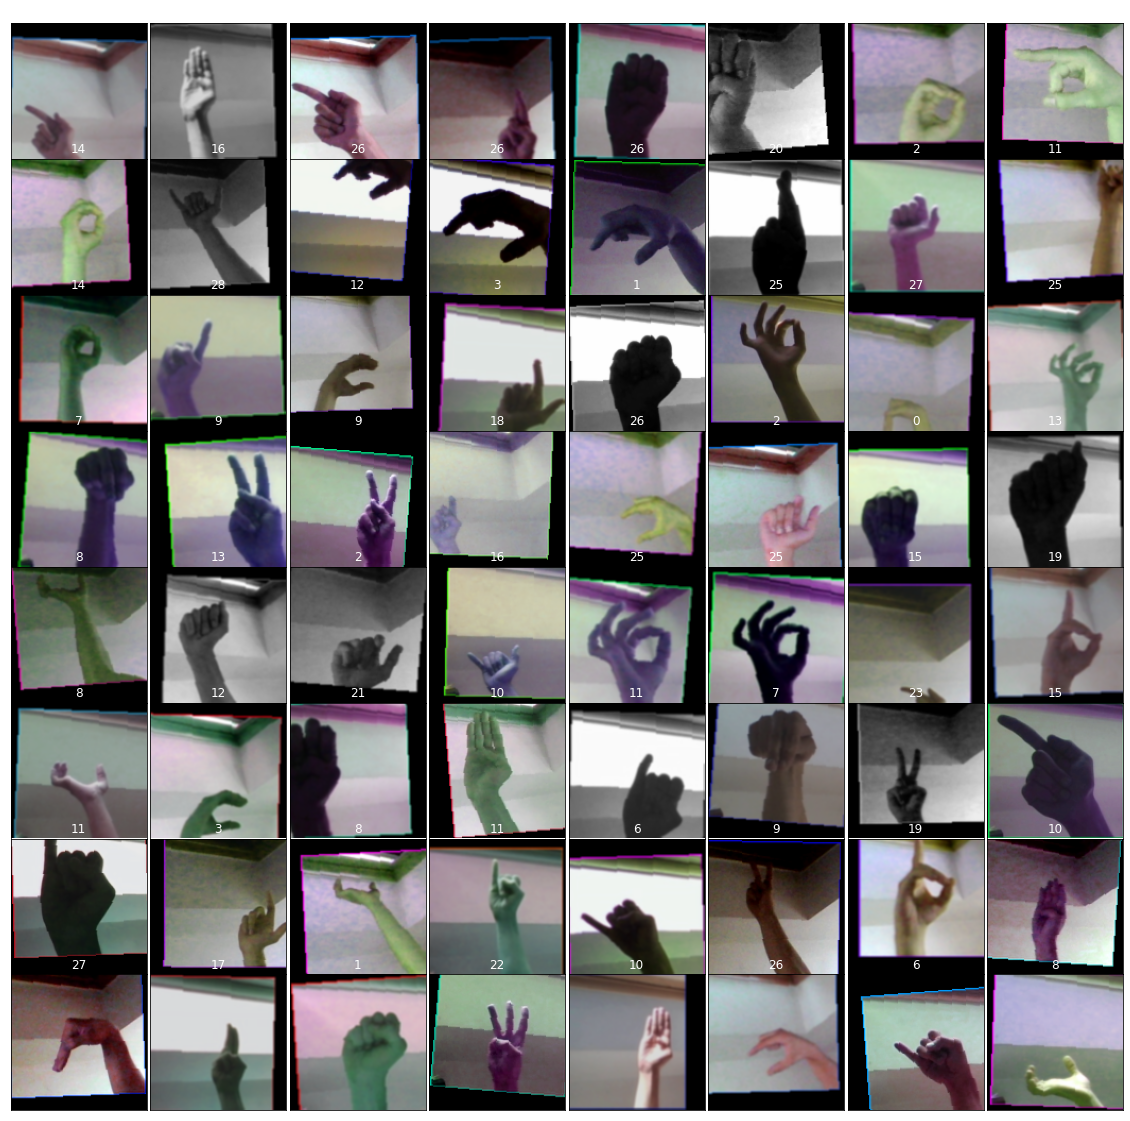

In [7]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

## Create the dataloaders

In [8]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

../Datasets/asl/source/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


Dataset sizes:
	training=68904
	validation=9396
	test=8700
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-5.0, 5.0], translate=(0.15, 0.15))
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)


../Datasets/asl/source/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


## Set up the device

In [6]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model

In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ASLClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Number of Model Params: 288773


## Set up the optimizer and loss

In [11]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[1, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({1: 1, 20: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [12]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

## Train the model

In [13]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 68904 samples (64 per mini-batch)
Epoch: [0][   50/ 1077]    objective_loss 3.348231                                        LR 0.001000    
Epoch: [0][  100/ 1077]    objective_loss 3.248454                                        LR 0.001000    
Epoch: [0][  150/ 1077]    objective_loss 3.128031                                        LR 0.001000    
Epoch: [0][  200/ 1077]    objective_loss 3.002641                                        LR 0.001000    
Epoch: [0][  250/ 1077]    objective_loss 2.881068                                        LR 0.001000    
Epoch: [0][  300/ 1077]    objective_loss 2.756523                                        LR 0.001000    
Epoch: [0][  350/ 1077]    objective_loss 2.620098                                        LR 0.001000    
Epoch: [0][  400/ 1077]    objective_loss 2.484910                                        LR 0.001000    
Epoch: [0][  450/ 1077]    objective_loss 2.353258                                        LR 0.001000 

QAT is starting!


Epoch: [1][   50/ 1077]    objective_loss 1.704607                                        LR 0.000500    
Epoch: [1][  100/ 1077]    objective_loss 1.642495                                        LR 0.000500    
Epoch: [1][  150/ 1077]    objective_loss 1.587904                                        LR 0.000500    
Epoch: [1][  200/ 1077]    objective_loss 1.536736                                        LR 0.000500    
Epoch: [1][  250/ 1077]    objective_loss 1.491186                                        LR 0.000500    
Epoch: [1][  300/ 1077]    objective_loss 1.448892                                        LR 0.000500    
Epoch: [1][  350/ 1077]    objective_loss 1.408573                                        LR 0.000500    
Epoch: [1][  400/ 1077]    objective_loss 1.370576                                        LR 0.000500    
Epoch: [1][  450/ 1077]    objective_loss 1.336027                                        LR 0.000500    
Epoch: [1][  500/ 1077]    objective_loss 1.30

## Visualize Embeddings

In [10]:
# domain --> source = 0, tagret = 1, both = 2
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,domain,to_pred=False):
    if domain == 0:
        _, test_set = conf.dataset_fn((test_batch_path+"/source/", conf.args), load_train=False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 1:
        _, test_set = conf.dataset_fn((test_batch_path+"/target/", conf.args), load_train=False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 2:
        _, source_test_set = conf.dataset_fn((test_batch_path+"/source/", conf.args), load_train=False, load_test=True)
        source_test_loader = DataLoader(source_test_set, batch_size=batch_size, shuffle=True)
        _, target_test_set = conf.dataset_fn((test_batch_path+"/target/", conf.args), load_train=False, load_test=True)
        target_test_loader = DataLoader(target_test_set, batch_size=batch_size, shuffle=True)

    

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    if domain == 0 or domain == 1:
        # get a batch of data
        (batch_imgs, batch_labels) = next(iter(test_loader))
        batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        preds = model(batch_imgs)
        embds = activation['fc1']

        # get the labels
        batch_label_strings = []
        for idx,label in enumerate(batch_labels):
            batch_label_strings.append(test_set.label_dict[label.item()])

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )
        
        if to_pred:
            print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))
    
    if domain == 2:

        # get a batch of data
        (source_batch_imgs, source_batch_labels) = next(iter(source_test_loader))
        source_batch_imgs,source_batch_labels = source_batch_imgs.to(conf.device), source_batch_labels.to(conf.device)
        (target_batch_imgs, target_batch_labels) = next(iter(target_test_loader))
        target_batch_imgs,target_batch_labels = target_batch_imgs.to(conf.device), target_batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        source_preds = model(source_batch_imgs)
        source_embds = activation['fc1']
        target_preds = model(target_batch_imgs)
        target_embds = activation['fc1']

        # get the labels
        source_batch_label_strings = []
        for idx,label in enumerate(source_batch_labels):
            source_batch_label_strings.append(source_test_set.label_dict[label.item()]+"_SRC")

        target_batch_label_strings = []
        for idx,label in enumerate(target_batch_labels):
            target_batch_label_strings.append(target_test_set.label_dict[label.item()]+"_TGT")

        batch_imgs = torch.cat((source_batch_imgs,target_batch_imgs))
        batch_labels = torch.cat((source_batch_labels,target_batch_labels))
        source_batch_label_strings.extend(target_batch_label_strings)
        embds = torch.cat((source_embds,target_embds))

        print(source_batch_label_strings)

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=source_batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )

### 1: Visualize office clusters from dataset and from camera  
* for the dataset images, set the test_batch_path to ../Datasets/office5/source/
* for the camera images, set the test_batch_path to ../Datasets/office5/target/  

We see that for this particular batch of images we get **65.00%** on the **camera** batch and **91.83%** on the **dataset** batch. When visualizing the output embeddings of the CNN encoder we also see that the dataset batch clusters better

In [12]:
# init the model
model = mod.ASLClassifier()

# create the embeddings
viz_embeddings("../Datasets/asl/",conf,128,"jupyter_logging/finetune_asl_run1___2022.07.15-142428/classifierbackbonenet_best.pth.tar",model,1,False)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/asl//target/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
Configuring device: MAX78000, simulate=False.


### 2: Visualize difference in domains
* path is ../Datasets/office5_both  

From the embeddings we can see that there is a shift between the domains, e.g. all the keyboard images should cluster together rather than form independent clusters based on the domain

In [19]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5_both/",conf,256,"jupyter_logging/finetune_office5___2022.07.13-142419/classifierbackbonenet_qat_best.pth.tar",model,False)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/office5_both/test
{'back_pack_camera': 0, 'mouse_dataset': 1, 'keyboard_dataset': 2, 'monitor_dataset': 3, 'mug_dataset': 4, 'back_pack_dataset': 5, 'keyboard_camera': 6, 'monitor_camera': 7, 'mug_camera': 8, 'mouse_camera': 9}
Configuring device: MAX78000, simulate=False.


# Step 3: Quantization and Synthesis
* this code block is not repeated later so reuse it for synthesizing the model after domain-adaptation

## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [1]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best.pth.tar jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best.pth.tar to jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best-q.pth.tar

Model keys (state_dict):
feature_extractor.conv1.output_shift, feature_extractor.conv1.weight_bits, feature_extractor.conv1.bias_bits, feature_extractor.conv1.quantize_activation, feature_extractor.conv1.adjust_output_shift, feature_extractor.conv1.shift_quantile, feature_extractor.conv1.op.weight, feature_extractor.conv2.output_shift, feature_extractor.conv2.weight_bits, feature_extractor.conv2.bias_bits, feature_extractor.conv2.quantize_activation, feature_extractor.conv2.adjust_output_shift, feature_extractor.conv2.shift_quantile, feature_extractor.conv2.op.weight, feature_extractor.conv3.output_shift, feature_extractor.conv3.weight_bits, feature_extractor.conv3.bias_bits, feature_extractor.conv3.quantize_activation, feature_extractor.

## Evaluate Quantized Model

Change virtual environment back to ai8x-training

## Import the needed modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

## set up the model, choose desired checkpoint and corresponding architecture

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#load_model_path = 'jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar-q.pth.tar'
#load_model_path = "jupyter_logging/finetune_office5___2022.07.07-161909/classifierbackbonenet_qat_best-q.pth.tar"
#load_model_path = "jupyter_logging/dcd_train_adv___2022.07.13-143739/officeclassifier_qat_best-q.pth.tar"
#load_model_path = "jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best-q.pth.tar"
load_model_path = "jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best-q.pth.tar"

# Change this path to match file system layout
#data_path = "../Datasets/office5_test_baseline/"
data_path = "../Datasets/asl/target/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.ASLClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


## Load the test data

In [4]:
args = Args(act_mode_8bit=True)

_, test_set = office5_get_datasets((data_path, args), load_train=False, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

../Datasets/asl/target/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


## Simple test loop

In [5]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 95.08%


## Create a sample image
* takes the first image from the test_loader
* change the name to be the model name

In [20]:
for image, label in test_dataloader:
    break
im_sample = (image[16].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_asl.npy', im_sample)

## Visualize the test image
* we can see if the model simulation classifies it correctly at the bottom of the log.txt

tensor(1)

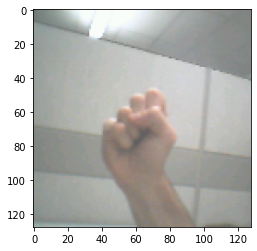

In [19]:
plt.imshow((image[16].detach().cpu().permute(1, 2, 0)+128)/255)
label[16]

## Model Synthesis
* make sure to specify the correct model path and configuration file

In [2]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix ASL_DA_k8 --checkpoint-file ../ai8x-training/jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best-q.pth.tar --config-file networks/classifier.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

/home/geffencooper/Model_Development/ai8x-synthesis


WARNING:

Configuring device: MAX78000
Reading networks/classifier.yaml to configure network...
Reading ../ai8x-training/jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best-q.pth.tar to configure network weights...
Checkpoint for epoch 2, model officeclassifier_qat - weight and bias data:
 InCh OutCh  Weights         Quant Shift  Min  Max    Size Key                                       Bias       Quant  Min  Max Size Key
    3     8  (24, 3, 3)          8     0  -80   60     216 feature_extractor.conv1.op.weight         N/A            0    0    0    0 N/A                      
    8     8  (64, 3, 3)          8     0  -97   71     576 feature_extractor.conv2.op.weight         N/A            0    0    0    0 N/A                      
    8    16  (128, 3, 3)         8     0 -107   60    1152 feature_extractor.conv3.op.weight         N/A            0    0    0    0 N/A                      
   16    16  (256, 3, 3)         8     0  -66   45    2304 feature_extr

Cannot check for updates for git branch "DA" from GitHub - Branch not found


WARNING:

Layer 11: `flatten` is not needed since input dimensions are 1x1.


WARNING:

ASL_DA_k8...


Layer 12: `flatten` is not needed since input dimensions are 1x1.


Output()

Output()

Output()

# Step 4: Now we do domain adaptation to improve the results  

## Let's first try a naive mix of the source and target training data

## Import the needed modules

In [4]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [6]:
class Config:
    def __init__(self):
        self.dataset_name = "asl"
        self.dataset_fn = asl_get_datasets
        self.num_classes = 29
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.12
        self.log_prefix = "finetune_asl_naive_mix_run3"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/asl/naive_mix/"
        self.deterministic = False
        self.print_freq = 50
        self.labels = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')
        self.lr = 0.001
        self.num_epochs = 4
        self.qat_policy = {'start_epoch':1, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

In [7]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_asl_naive_mix_run3___2022.07.18-110214/finetune_asl_naive_mix_run3___2022.07.18-110214.log
dataset_name:asl
dataset_fn=<function asl_get_datasets at 0x7f40089c28b0>
num_classes=29
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.12
lr=0.001000
num_epochs=4
qat_policy={'start_epoch': 1, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



../Datasets/asl/naive_mix/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


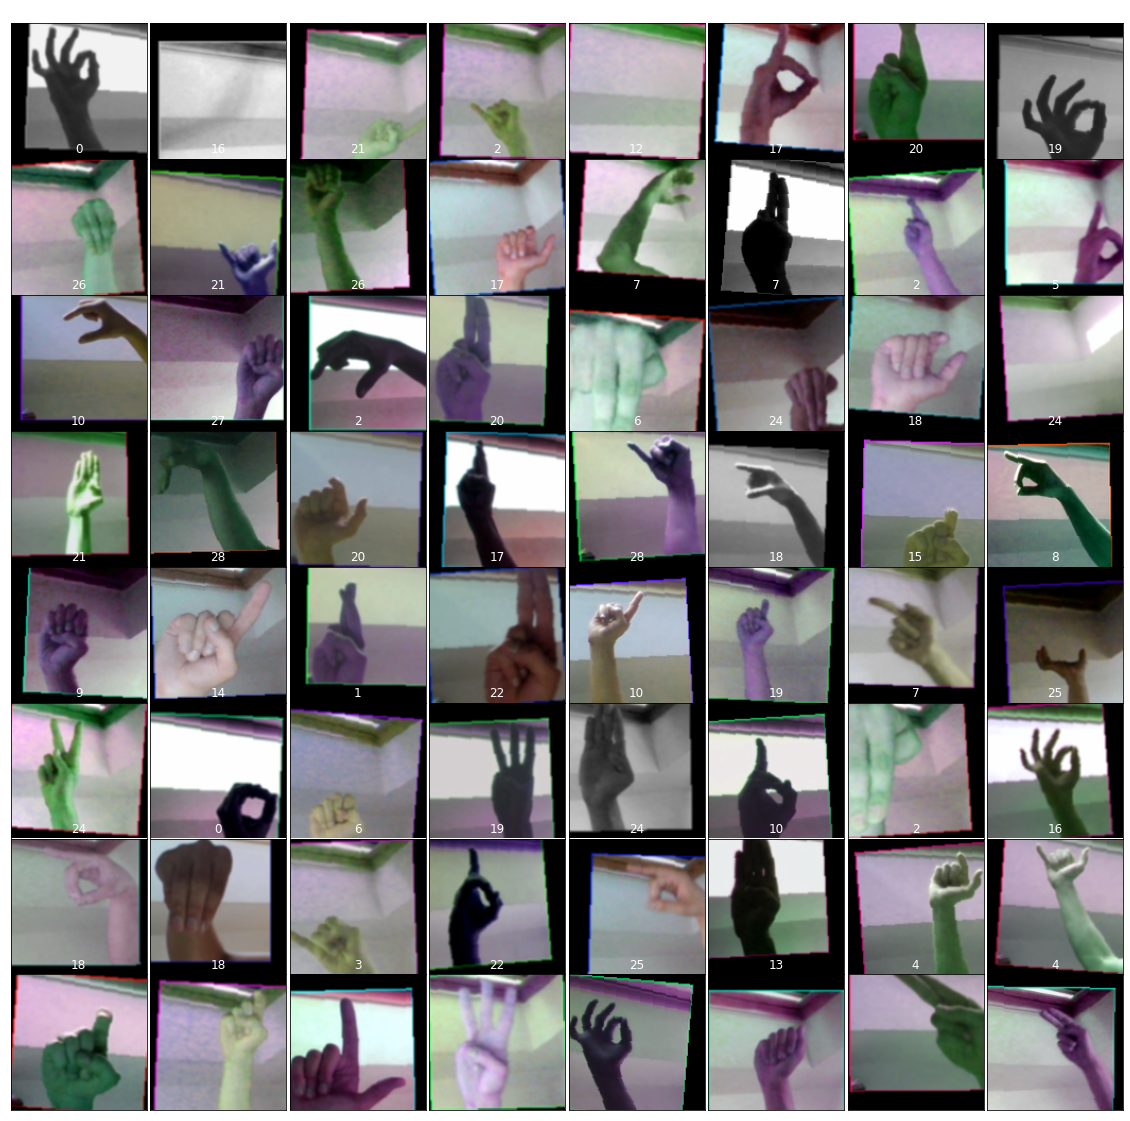

In [8]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

In [9]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

../Datasets/asl/naive_mix/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


Dataset sizes:
	training=69179
	validation=9433
	test=325
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-5.0, 5.0], translate=(0.15, 0.15))
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)


../Datasets/asl/naive_mix/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}


In [10]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


In [11]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ASLClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Number of Model Params: 288773


In [12]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[1, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({1: 1, 20: 1, 100: 1}) gamma: 0.5


In [13]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

In [14]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 69179 samples (32 per mini-batch)
Epoch: [0][   50/ 2162]    objective_loss 3.369777                                        LR 0.001000    
Epoch: [0][  100/ 2162]    objective_loss 3.370626                                        LR 0.001000    
Epoch: [0][  150/ 2162]    objective_loss 3.370219                                        LR 0.001000    
Epoch: [0][  200/ 2162]    objective_loss 3.369603                                        LR 0.001000    
Epoch: [0][  250/ 2162]    objective_loss 3.369297                                        LR 0.001000    
Epoch: [0][  300/ 2162]    objective_loss 3.368847                                        LR 0.001000    
Epoch: [0][  350/ 2162]    objective_loss 3.364053                                        LR 0.001000    
Epoch: [0][  400/ 2162]    objective_loss 3.346451                                        LR 0.001000    
Epoch: [0][  450/ 2162]    objective_loss 3.315545                                        LR 0.001000 

QAT is starting!


Epoch: [1][   50/ 2162]    objective_loss 1.860559                                        LR 0.000500    
Epoch: [1][  100/ 2162]    objective_loss 1.808107                                        LR 0.000500    
Epoch: [1][  150/ 2162]    objective_loss 1.773818                                        LR 0.000500    
Epoch: [1][  200/ 2162]    objective_loss 1.742160                                        LR 0.000500    
Epoch: [1][  250/ 2162]    objective_loss 1.711448                                        LR 0.000500    
Epoch: [1][  300/ 2162]    objective_loss 1.683991                                        LR 0.000500    
Epoch: [1][  350/ 2162]    objective_loss 1.656591                                        LR 0.000500    
Epoch: [1][  400/ 2162]    objective_loss 1.629706                                        LR 0.000500    
Epoch: [1][  450/ 2162]    objective_loss 1.602908                                        LR 0.000500    
Epoch: [1][  500/ 2162]    objective_loss 1.57

In [15]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False):
    _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [22]:
# init the model
model = mod.ASLClassifier()

# create the embeddings
viz_embeddings("../Datasets/asl/source/",conf,512,"jupyter_logging/finetune_asl_naive_mix_run3___2022.07.18-110214/classifierbackbonenet_qat_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/asl/source/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
Configuring device: MAX78000, simulate=False.
batch acc:  0.998046875


In [ ]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5_both/",conf,256,"jupyter_logging/finetune_office5___2022.07.13-142419/classifierbackbonenet_qat_best.pth.tar",model,False)

## Now we will do domain adaptation: First we will train the discriminator

## Reload the modules

In [6]:
%load_ext autoreload
%autoreload 2

In [34]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## New Training Parameters for discriminator

In [35]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "asldcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "asl_dcd_train_k8"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/asl/source/"
        self.target_data_path = "../Datasets/asl/target/"
        self.deterministic = True
        self.print_freq = 100
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.0015
        self.num_epochs = 32
        self.qat_policy = {'start_epoch':4, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

## Set up the logger

In [36]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/asl_dcd_train_k8___2022.07.18-113000/asl_dcd_train_k8___2022.07.18-113000.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets at 0x7f40089c25e0>
num_classes=4
model_name=asldcdnet
dimensions=(1, 128)
batch_size=32
validation_split=0.1
lr=0.001500
num_epochs=32
qat_policy={'start_epoch': 4, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and Visualize the dataset
* each sample is a pair of images sampled from G1, G2, G3, G4
* G1 --> same domain, same class
* G2 --> different domain, same class
* G3 --> same domain, different class
* G4 --> different domain, different class
* the first label is the pair label, the parentheses label is the class label

../Datasets/asl/source/train
../Datasets/asl/target/train
../Datasets/asl/source/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
../Datasets/asl/target/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
Max possible pairs: G1 =  105665850  G2 =  626400  G3 =  3065405850  G4 =  17539200
../Datasets/asl/source/test
../Datasets/asl/target/test
../Datasets/asl/source/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20

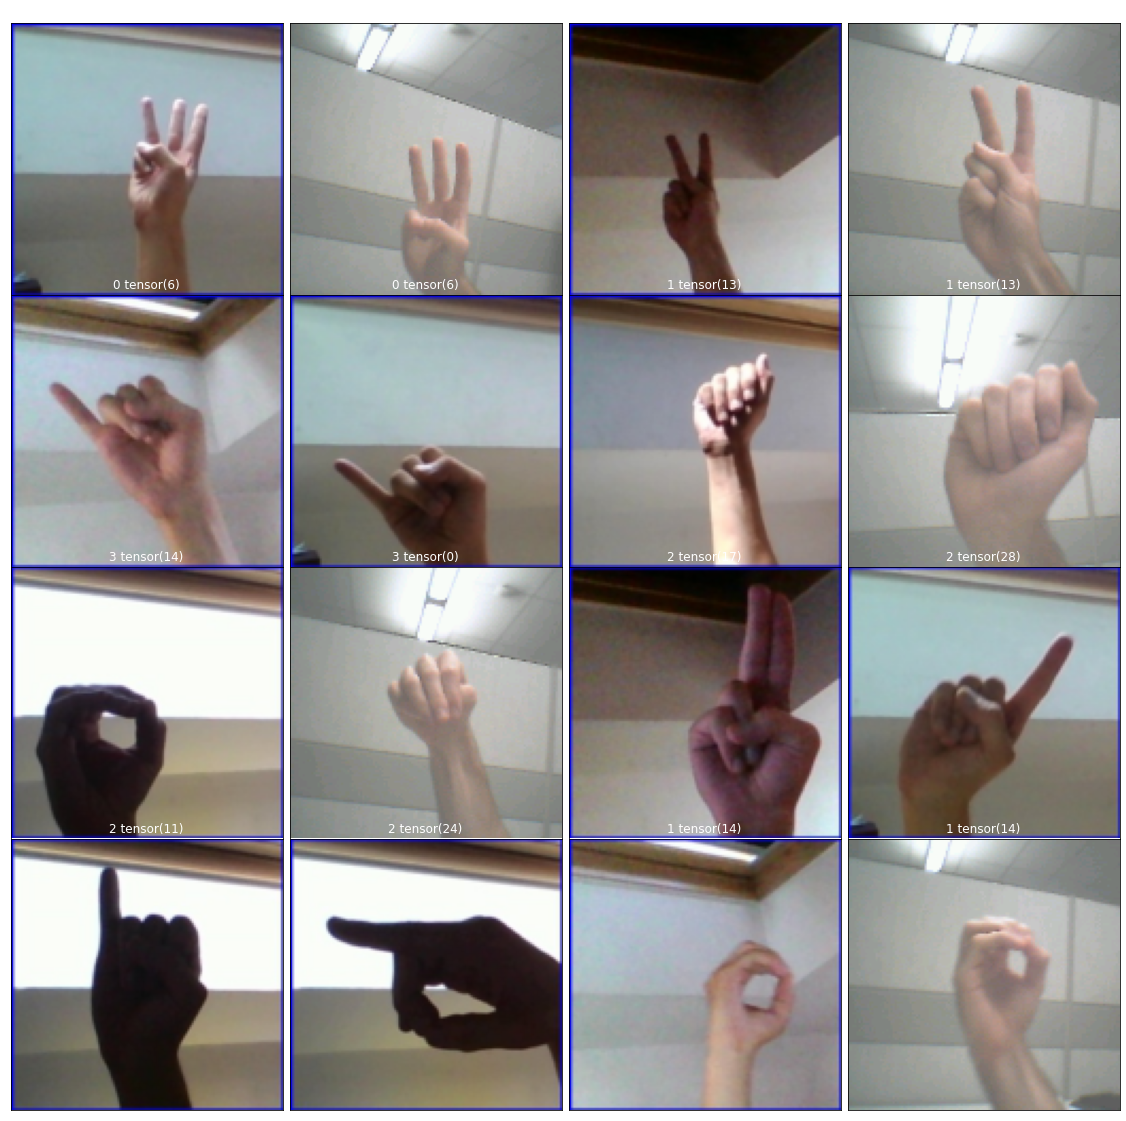

In [37]:
train_set, test_set = conf.dataset_fn(((conf.source_data_path,conf.target_data_path), args), load_train=True, load_test=True)
train_set.visualize_batch()

## Create the dataloaders

In [38]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, ((conf.source_data_path,conf.target_data_path), args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

../Datasets/asl/source/train
../Datasets/asl/target/train
../Datasets/asl/source/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
../Datasets/asl/target/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
Max possible pairs: G1 =  105665850  G2 =  626400  G3 =  3065405850  G4 =  17539200
../Datasets/asl/source/test
../Datasets/asl/target/test
../Datasets/asl/source/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20

Dataset sizes:
	training=56376
	validation=6264
	test=6960
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)


## Set up the device

In [39]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model

In [40]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ASLDCD()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ASLDCD(
  (fc1): FusedLinearReLU(
    (activate): ReLU(inplace=True)
    (op): Linear(in_features=128, out_features=64, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (fc2): Linear(
    (activate): Empty()
    (op): Linear(in_features=64, out_features=4, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (do): Dropout(p=0.2, inplace=False)
)
Number of Model Param

Configuring device: MAX78000, simulate=False.


In [41]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.0015] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [42]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/finetune_asl_run2___2022.07.18-092902/classifierbackbonenet_qat_best.pth.tar"
enc_model = mod.ASLClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf.device)

# register a forward hook to get the encoder output
conf.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
conf.enc_model = enc_model

def cd_DCD_forward(model, batch, conf):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

conf.forward = cd_DCD_forward

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

In [161]:
# %load_ext autoreload
# %autoreload 2

In [43]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 56376 samples (32 per mini-batch)
Epoch: [0][  100/ 1762]    objective_loss 1.259983                                        LR 0.001500    
Epoch: [0][  200/ 1762]    objective_loss 1.153294                                        LR 0.001500    
Epoch: [0][  300/ 1762]    objective_loss 1.072408                                        LR 0.001500    
Epoch: [0][  400/ 1762]    objective_loss 1.007959                                        LR 0.001500    
Epoch: [0][  500/ 1762]    objective_loss 0.955979                                        LR 0.001500    
Epoch: [0][  600/ 1762]    objective_loss 0.908851                                        LR 0.001500    
Epoch: [0][  700/ 1762]    objective_loss 0.875184                                        LR 0.001500    
Epoch: [0][  800/ 1762]    objective_loss 0.846036                                        LR 0.001500    
Epoch: [0][  900/ 1762]    objective_loss 0.820021                                        LR 0.001500 

QAT is starting!


Epoch: [4][  100/ 1762]    objective_loss 0.904504                                        LR 0.001500    
Epoch: [4][  200/ 1762]    objective_loss 0.879086                                        LR 0.001500    
Epoch: [4][  300/ 1762]    objective_loss 0.859128                                        LR 0.001500    
Epoch: [4][  400/ 1762]    objective_loss 0.843755                                        LR 0.001500    
Epoch: [4][  500/ 1762]    objective_loss 0.830061                                        LR 0.001500    
Epoch: [4][  600/ 1762]    objective_loss 0.846022                                        LR 0.001500    
Epoch: [4][  700/ 1762]    objective_loss 0.865843                                        LR 0.001500    
Epoch: [4][  800/ 1762]    objective_loss 0.879383                                        LR 0.001500    
Epoch: [4][  900/ 1762]    objective_loss 0.888311                                        LR 0.001500    
Epoch: [4][ 1000/ 1762]    objective_loss 0.89

## Now do adversarial training to trick the discriminator

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger
import torch.nn.functional as F

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "asldcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 64
        self.validation_split = 0.1
        self.log_prefix = "asl_dcd_train_adv_k8run3"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/asl/source/"
        self.target_data_path = "../Datasets/asl/target/"
        self.deterministic = True
        self.print_freq = 32
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.001
        self.num_epochs = 8
        self.qat_policy = {'start_epoch':2, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.adv_criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.dcd_model = None

conf_c = Config()
conf_c.lr = 0.001
conf_c.num_classes = 29
conf_c.labels = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')
conf_c.model_name = "aslclassifier"
conf_c.dimensions = (3,128,128)
conf_c.batch_size = 64
conf_c.dataset_fn = pairs_get_datasets_c
conf_d = Config()
conf_cd = Config()

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf_c.log_prefix, conf_c.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf_c.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf_c.dataset_name,conf_c.dataset_fn,conf_c.num_classes,conf_c.model_name,conf_c.dimensions,conf_c.batch_size,conf_c.validation_split,conf_c.lr,conf_c.num_epochs,conf_c.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/asl_dcd_train_adv_k8run3___2022.07.18-125521.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets_c at 0x7f57cceca700>
num_classes=29
model_name=officeclassifier
dimensions=(3, 128, 128)
batch_size=64
validation_split=0.1
lr=0.001000
num_epochs=8
qat_policy={'start_epoch': 2, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



In [4]:
train_loader_c, val_loader_c, test_loader_c, _ = apputils.get_data_loaders(conf_c.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_c.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
train_loader_d, val_loader_d, test_loader_d, _ = apputils.get_data_loaders(conf_d.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_d.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
# _, _, test_loader, _ = apputils.get_data_loaders(cats_and_dogs_get_datasets, ("../Datasets/cats_and_dogs/",args), 32, 1, 0.1, True,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader_c.sampler), len(val_loader_c.sampler), len(test_loader_c.sampler))
msglogger.info('Augmentations:%s',train_loader_c.dataset.transform)

../Datasets/asl/source/train
../Datasets/asl/target/train
../Datasets/asl/source/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
../Datasets/asl/target/train
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
Max possible pairs: G1 =  105665850  G2 =  626400  G3 =  3065405850  G4 =  17539200
../Datasets/asl/source/test
../Datasets/asl/target/test
../Datasets/asl/source/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20

Dataset sizes:
	training=28188
	validation=3132
	test=3480
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)


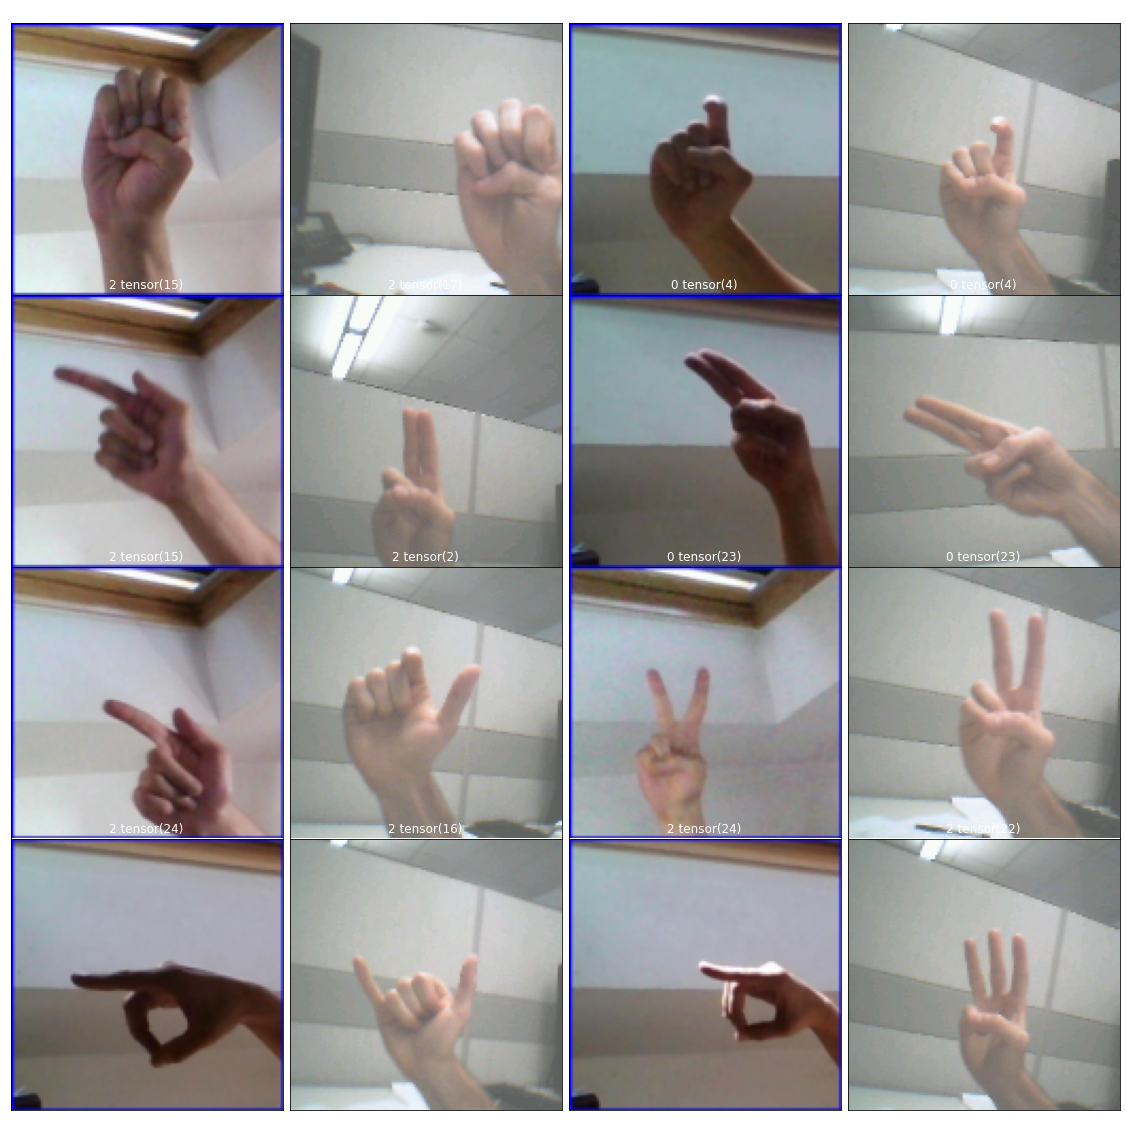

In [5]:
train_loader_c.dataset.visualize_batch()

In [6]:
conf_c.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_d.device = conf_c.device
print('Running on device: {}'.format(conf_c.device))

Running on device: cuda:0


In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the classifier model
load_model_path = "jupyter_logging/finetune_asl_run2___2022.07.18-092902/classifierbackbonenet_qat_best.pth.tar"
enc_model = mod.ASLClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf_c.device)

# create the DCD model
load_model_path = "jupyter_logging/asl_dcd_train_k8___2022.07.18-113000/asldcdnet_qat_best.pth.tar"
dcd_model = mod.ASLDCD()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(dcd_model)
dcd_model = apputils.load_lean_checkpoint(dcd_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(dcd_model)
dcd_model = dcd_model.to(conf_c.device)

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf_c.dimensions)
tflogger.tblogger.writer.add_graph(enc_model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


=> loaded 'state_dict' from checkpoint 'jupyter_logging/finetune_asl_run2___2022.07.18-092902/classifierbackbonenet_qat_best.pth.tar'
=> loading checkpoint jupyter_logging/asl_dcd_train_k8___2022.07.18-113000/asldcdnet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------+
| Key                  | Type        | Value         |
|----------------------+-------------+---------------|
| arch                 | str         | asldcdnet_qat |
| compression_sched    | dict        |               |
| epoch                | int         | 20            |
| extras               | dict        |               |
| optimizer_state_dict | dict        |               |
| optimizer_type       | type        | Adam          |
| state_dict           | OrderedDict |               |
+----------------------+-------------+---------------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---

In [8]:
# optimizer
conf_c.optimizer = optim.Adam(enc_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_c.optimizer))

conf_d.optimizer = optim.Adam(dcd_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_d.optimizer))

# lr schedule
conf_c.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_c.optimizer, milestones=[2, 20,100], gamma=0.5)
conf_d.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_d.optimizer, milestones=[2, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf_c.lr_scheduler.base_lrs)+" milestones: "+str(conf_c.lr_scheduler.milestones)+ " gamma: "+str(conf_c.lr_scheduler.gamma))

def dcd_adv_loss(output, target):
    g2s = F.log_softmax(output[target == 0])
    g4s = F.log_softmax(output[target == 2])

    # print("output: ", output)
    # print("target: ", target)

    # print("G2 log-softmax: ", g2s)
    # print("G4 log-softmax: ", g2s)

    term_1 = F.nll_loss(g2s,target[target == 0])
    term_2 = -F.nll_loss(g4s,target[target == 2])

    # print("term 1: ", term_1)
    # print("term 2: ", term_2)
    # () + 1
    
    return term_1 + term_2 

# loss function
#conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_c.device)
conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
conf_c.adv_criterion = dcd_adv_loss
conf_d.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
compression_scheduler_c = distiller.CompressionScheduler(enc_model)
compression_scheduler_d = distiller.CompressionScheduler(dcd_model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({2: 1, 20: 1, 100: 1}) gamma: 0.5


In [9]:
# register a forward hook to get the encoder output
conf_c.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf_c.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
enc_model = enc_model.to(conf_c.device)
conf_c.enc_model = enc_model

conf_d.dcd_model = dcd_model

def cd_DCD_forward(model, batch, conf, conf_c):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf_c.enc_model(inputs1)
    enc1 = conf_c.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf_c.enc_model(inputs2)
    enc2 = conf_c.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

def cd_classifier_forward(model, batch, conf, conf_d):
    inputs1, inputs2, target, imgs1_labels, imgs2_labels = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)

    # the dcd output and target as well as the classifier outputs and targets
    return conf_d.dcd_model(X_cat.detach()), target, model(inputs1), imgs1_labels, model(inputs2), imgs2_labels

def cd_classifier_forward2(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf_d.forward = cd_DCD_forward
conf_c.forward = cd_classifier_forward
conf_cd.forward = cd_classifier_forward2
conf_cd.device = conf_d.device
conf_cd.criterion = conf_c.criterion
conf_cd.num_classes = conf_c.num_classes


In [10]:
batch = next(iter(test_loader_d))
out, target = conf_d.forward(dcd_model,batch,conf_d,conf_c)
print(torch.argmax(out,axis=1)-target)

tensor([ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0, -1,  2,
         0, -1,  2, -2,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
         1, -1,  0,  1,  0,  0,  1,  0,  1, -1], device='cuda:0')


In [11]:
def adv_validate(val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, loggers, epoch=-1, tflogger=-1):
    
    # store loss stats
    enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
    disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

    classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
    classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
    classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

    # validation set info
    total_samples = len(val_loader_c.sampler)
    batch_size = val_loader_c.batch_size

    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)
    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

    total_steps = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

    # Switch to evaluation mode
    classifier_model.eval()
    discriminator_model.eval()

    class_probs = []
    class_preds = []
    dcd_c_probs = []
    dcd_c_preds = []
    dcd_d_probs = []
    dcd_d_preds = []

    # iterate over the batches in the validation set
    for validation_step in range(32):
        with torch.no_grad():
            
            batch_c = next(iter(val_loader_c)) # get a single batch
            batch_d = next(iter(val_loader_d))

            # pass the input through the classifier
            dcd_out_c, dcd_target_c, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch_c, conf_c, conf_d)
            # print("output: ", dcd_out_c)
            # print("target: ", dcd_target_c)

            # pass the input through the dcd
            dcd_out_d, dcd_target_d = conf_d.forward(discriminator_model, batch_d, conf_d, conf_c)
            
            # print(conf_c.device)
            # print(conf_d.device)
            # print("model on gpu:", next(classifier_model.parameters()).is_cuda)
            # print("model on gpu:", next(discriminator_model.parameters()).is_cuda)

            # correct output for accurate loss calculation
            if conf_c.args.act_mode_8bit:
                dcd_out_c /= 128.
                dcd_out_d /= 128.
                img1_out /= 128.
                img2_out /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        dcd_out_c /= 256.
                        dcd_out_d /= 256.
                        img1_out /= 256.
                        img2_out /= 256.
            
            # collect all the losses
            dcd_loss = conf_c.adv_criterion(dcd_out_c, dcd_target_c)
            img1_loss = conf_c.criterion(img1_out, img1_target)
            img2_loss = conf_c.criterion(img2_out, img2_target)
            loss = dcd_loss + img1_loss + img2_loss
            enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
            enc_losses['disc_c_loss'].add(dcd_loss.item())

            # collect accuracy stats
            classerr_class.add(img1_out.data, img1_target)
            classerr_class.add(img2_out.data, img2_target)
            classerr_disc_c.add(dcd_out_c.data, dcd_target_c)

            confusion_class.add(img1_out.data, img1_target)
            confusion_class.add(img2_out.data, img2_target)
            confusion_disc_c.add(dcd_out_c.data, dcd_target_c)


            dcd_loss_d = conf_d.criterion(dcd_out_d, dcd_target_d)
            disc_losses['disc_d_loss'].add(dcd_loss_d.item())

            classerr_disc_d.add(dcd_out_d.data, dcd_target_d)
            confusion_disc_d.add(dcd_out_d.data, dcd_target_d)
            

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf_c.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in torch.cat((img1_out,img2_out))]
                dcd_c_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_c]
                dcd_d_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_d]

                _, class_preds_batch = torch.max(torch.cat((img1_out,img2_out)), 1)
                _, dcd_c_preds_batch = torch.max(dcd_out_c, 1)
                _, dcd_d_preds_batch = torch.max(dcd_out_d, 1)

                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)
                dcd_c_probs.append(dcd_c_probs_batch)
                dcd_c_preds.append(dcd_c_preds_batch)
                dcd_d_probs.append(dcd_d_probs_batch)
                dcd_d_preds.append(dcd_d_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Class Loss', enc_losses['class_loss'].mean),
                                 ('disc_c Loss', enc_losses['disc_c_loss'].mean),
                                 ('disc_d Loss', disc_losses['disc_d_loss'].mean),
                                    ('Class Top1', classerr_class.value(1)),
                                    ('disc_c Top1', classerr_disc_c.value(1)),
                                    ('disc_d Top1', classerr_disc_d.value(1))]),
                                    
                )
                if conf_c.num_classes > 5:
                    stats[1]['Top5'] = classerr_class.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, conf_c.print_freq, loggers)


    if conf_c.num_classes > 5:
        msglogger.info('==> Class Top1: %.3f    Class Top5: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0], classerr_class.value()[1],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)
    else:
        msglogger.info('==> Class Top1: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)

    msglogger.info('==> Confusion Class:\n%s\n', str(confusion_class.value()))
    msglogger.info('==> Confusion DCD_c:\n%s\n', str(confusion_disc_c.value()))
    msglogger.info('==> Confusion DCD_d:\n%s\n', str(confusion_disc_d.value()))

    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion_class.value(), conf_c.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_class', cf, epoch,
                                            dataformats='HWC')
        cf = nnplot.confusion_matrix(confusion_disc_c.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_c', cf, epoch,
                                            dataformats='HWC')

        cf = nnplot.confusion_matrix(confusion_disc_d.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_d', cf, epoch,
                                            dataformats='HWC')
    
    return classerr_class.value(1), classerr_class.value(min(conf_c.num_classes, 5)), enc_losses['class_loss'].mean, classerr_disc_c.value(1), enc_losses['disc_c_loss'].mean, classerr_disc_d.value(1), disc_losses['disc_d_loss'].mean

In [12]:
def adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, conf_cd):

    # store model history across epochs
    perf_scores_history = []

    classifier_model = classifier_model.to(conf_c.device)
    discriminator_model = discriminator_model.to(conf_d.device)

    # start the clock
    tic = datetime.now()

    batches_per_phase = 2

    # =============================== training loop =====================================
    for epoch in range(0, conf_c.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf_c.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(classifier_model)
            ai8x.fuse_bn_layers(discriminator_model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(classifier_model, conf_c.qat_policy)
            ai8x.initiate_qat(discriminator_model, conf_d.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            classifier_model.to(conf_c.device)
            discriminator_model.to(conf_d.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf_c.model_name = f'{conf_c.model_name}_qat'
            conf_d.model_name = f'{conf_d.model_name}_qat'

        # store loss and training stats
        enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
        disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

        classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
        classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
        classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

        # logging stats
        total_samples = len(train_loader_c.sampler)
        steps_per_epoch = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

        # Switch to train mode
        classifier_model.train()
        discriminator_model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        encoder_on = False
        switch_d = False
        switch_c = False

        print("steps in an epoch:", len(train_loader_c))

        #for train_step, batch in enumerate(train_loader_c):
        for train_step in range(64): # reduce epocj to 64 batches since we are randomly sampling
            # switch phase every four batches
            if (train_step % batches_per_phase) == 0:
                if encoder_on == True: # switch to train dcd
                    switch_d = True
                if encoder_on == False: # switch to train encoder
                    switch_c = True
                encoder_on = not encoder_on

            # train the encoder to trick the discriminator
            if encoder_on:
                if switch_c == True: # create new error collectors at the start of the phase
                    switch_c = False
                    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
                    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_c)) # get a single batch

                # pass the input through the classifier
                dcd_out, dcd_target, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch, conf_c, conf_d) 
                
                # collect all the losses
                dcd_loss = conf_c.adv_criterion(dcd_out, dcd_target)
                img1_loss = conf_c.criterion(img1_out, img1_target)
                img2_loss = conf_c.criterion(img2_out, img2_target)
                loss = dcd_loss + img1_loss + img2_loss

                # collect accuracy stats
                classerr_class.add(img1_out.data, img1_target)
                classerr_class.add(img2_out.data, img2_target)
                classerr_disc_c.add(dcd_out.data, dcd_target)

                confusion_class.add(img1_out.data, img1_target)
                confusion_class.add(img2_out.data, img2_target)
                confusion_disc_c.add(dcd_out.data, dcd_target)
                
                # add the losses
                enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
                enc_losses['disc_c_loss'].add(dcd_loss.item())

                # reset the optimizer
                conf_c.optimizer.zero_grad()

                # backwards pass and parameter update
                loss.backward()
                conf_c.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats
                if (steps_completed+batches_per_phase) % conf_c.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_class.n != 0:
                        errs['class Top1'] = classerr_class.value(1)
                        errs['disc_c Top1'] = classerr_disc_c.value(1)
                        if conf_c.num_classes > 5:
                            errs['class Top5'] = classerr_class.value(5)
                    else:
                        errs['class Top1'] = None
                        errs['class Top5'] = None
                        errs['disc_c Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in enc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_c.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_c/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_c.print_freq,all_loggers)

            # train the discriminator
            else:
                if switch_d == True:
                    switch_d = False
                    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_d))

                # pass the input through the dcd
                dcd_out, dcd_target = conf_d.forward(discriminator_model, batch, conf_d, conf_c) 
                
                dcd_loss_d = conf_d.criterion(dcd_out, dcd_target)

                classerr_disc_d.add(dcd_out.data, dcd_target)
                confusion_disc_d.add(dcd_out.data, dcd_target)
                
                disc_losses['disc_d_loss'].add(dcd_loss_d.item())

                # reset the optimizer
                conf_d.optimizer.zero_grad()

                # backwards pass and parameter update
                dcd_loss_d.backward()
                conf_d.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats every 10 batches
                if steps_completed % conf_d.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_disc_d.n != 0:
                        errs['disc_d Top1'] = classerr_disc_d.value(1)
                    else:
                        errs['disc_d Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in disc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_d.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_d/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_d.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        class_top1, class_top5, class_loss, disc_c_top1, disc_c_loss, disc_d_top1, disc_d_loss = adv_validate(val_loader_c, val_loader_d, classifier_model,\
                                                                                                          conf_c, discriminator_model, conf_d, [pylogger], epoch, tflogger)

        # store validation stats
        stats = (
                    'Adv/Validation/',
                    OrderedDict([('Class Loss', class_loss),
                                 ('disc_c Loss', disc_c_loss),
                                 ('disc_d Loss', disc_d_loss),
                                    ('Class Top1', class_top1),
                                    ('disc_c Top1', disc_c_top1),
                                    ('disc_d Top1', disc_d_top1)]),
                                    
                )
        
        if conf_c.num_classes > 5:
            stats[1]['Top5'] = classerr_class.value(5)

        distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                log_freq=1, loggers=all_tbloggers)

        perf_scores_history.append(distiller.MutableNamedTuple({'disc_d_loss': disc_d_loss, 'epoch': epoch}))
        # Keep perf_scores_history sorted from best to worst
        # Sort by top1 as main sort key, then sort by top5 and epoch
        perf_scores_history.sort(key=operator.attrgetter('disc_d_loss','epoch'),reverse=True)
        for score in perf_scores_history[:1]:
            msglogger.info('==> Best [disc_d_loss: %.3f on epoch: %d]',
                            score.disc_d_loss, score.epoch)

        # Save the checkpoint
        is_best = epoch == perf_scores_history[0].epoch
        checkpoint_extras = {'current_disc_d_loss': disc_d_loss,
                            'best_disc_d_loss': perf_scores_history[0].disc_d_loss,
                            'best_epoch': perf_scores_history[0].epoch}

        apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                    scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                    is_best=is_best, name=conf_c.model_name,
                                    dir=msglogger.logdir)

        conf_c.lr_scheduler.step()
        conf_d.lr_scheduler.step()

    # ========================= test ============================
    # top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
    # msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

In [13]:
adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, enc_model, conf_c, dcd_model, conf_d, conf_cd)

Training epoch: 28188 samples (64 per mini-batch)


steps in an epoch: 441


/tmp/ipykernel_2904939/670386604.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g2s = F.log_softmax(output[target == 0])

/tmp/ipykernel_2904939/670386604.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g4s = F.log_softmax(output[target == 2])

Epoch: [0][   30/  441]    class_loss 0.850709    disc_c_loss 0.119490    class Top1 92.919922    disc_c Top1 52.832031    class Top5 98.046875    LR 0.001000    
Epoch: [0][   32/  441]    disc_d_loss 0.966686    disc_d Top1 62.304688    LR 0.001000    
Epoch: [0][   62/  441]    class_loss 0.635601    disc_c_loss -0.102043    class Top1 96.264648    disc_c Top1 56.738281    class Top5 98.852539    LR 0.001000    
Epoch: [0][   64/  441]    disc_d_loss 0.961276    disc_d Top1 59.667969    LR 0.001000    
--- validate (epoch=0)-----------
3132 samples (64 per mini-batch)
Epoc

steps in an epoch: 441


Epoch: [1][   30/  441]    class_loss 0.358836    disc_c_loss -0.308429    class Top1 100.000000    disc_c Top1 63.183594    class Top5 100.000000    LR 0.001000    
Epoch: [1][   32/  441]    disc_d_loss 0.866179    disc_d Top1 58.691406    LR 0.001000    
Epoch: [1][   62/  441]    class_loss 0.352252    disc_c_loss -0.301148    class Top1 100.000000    disc_c Top1 62.695312    class Top5 100.000000    LR 0.001000    
Epoch: [1][   64/  441]    disc_d_loss 0.842463    disc_d Top1 59.521484    LR 0.001000    
--- validate (epoch=1)-----------
3132 samples (64 per mini-batch)
Epoch: [1][   32/   49]    Class Loss 0.344098    disc_c Loss -0.253975    disc_d Loss 0.803153    Class Top1 100.000000    disc_c Top1 58.593750    disc_d Top1 62.451172    Top5 100.000000    
==> Class Top1: 100.000    Class Top5: 100.000    Class Loss: 0.344    DCD_c Top1: 58.594 DCD_c Loss: -0.254    DCD_d Top1: 62.451 DCD_d Loss: 0.803

==> Confusion Class:
[[131   0   0   0   0   0   0   0   0   0   0   0   

QAT is starting!
steps in an epoch: 441


Epoch: [2][   30/  441]    class_loss 0.345515    disc_c_loss -0.305139    class Top1 100.000000    disc_c Top1 57.128906    class Top5 100.000000    LR 0.000500    
Epoch: [2][   32/  441]    disc_d_loss 0.798491    disc_d Top1 64.843750    LR 0.000500    
Epoch: [2][   62/  441]    class_loss 0.337769    disc_c_loss -0.285924    class Top1 100.000000    disc_c Top1 56.542969    class Top5 100.000000    LR 0.000500    
Epoch: [2][   64/  441]    disc_d_loss 0.801234    disc_d Top1 63.134766    LR 0.000500    
--- validate (epoch=2)-----------
3132 samples (64 per mini-batch)
Epoch: [2][   32/   49]    Class Loss 0.330928    disc_c Loss -0.255830    disc_d Loss 0.777888    Class Top1 100.000000    disc_c Top1 59.960938    disc_d Top1 65.625000    Top5 100.000000    
==> Class Top1: 100.000    Class Top5: 100.000    Class Loss: 0.331    DCD_c Top1: 59.961 DCD_c Loss: -0.256    DCD_d Top1: 65.625 DCD_d Loss: 0.778

==> Confusion Class:
[[144   0   0   0   0   0   0   0   0   0   0   0   

steps in an epoch: 441


Epoch: [3][   30/  441]    class_loss 0.328873    disc_c_loss -0.282167    class Top1 100.000000    disc_c Top1 59.765625    class Top5 100.000000    LR 0.000500    
Epoch: [3][   32/  441]    disc_d_loss 0.793892    disc_d Top1 63.085938    LR 0.000500    
Epoch: [3][   62/  441]    class_loss 0.328073    disc_c_loss -0.281689    class Top1 100.000000    disc_c Top1 57.373047    class Top5 100.000000    LR 0.000500    
Epoch: [3][   64/  441]    disc_d_loss 0.785378    disc_d Top1 64.208984    LR 0.000500    
--- validate (epoch=3)-----------
3132 samples (64 per mini-batch)
Epoch: [3][   32/   49]    Class Loss 0.324654    disc_c Loss -0.293178    disc_d Loss 0.771950    Class Top1 100.000000    disc_c Top1 54.394531    disc_d Top1 66.699219    Top5 100.000000    
==> Class Top1: 100.000    Class Top5: 100.000    Class Loss: 0.325    DCD_c Top1: 54.395 DCD_c Loss: -0.293    DCD_d Top1: 66.699 DCD_d Loss: 0.772

==> Confusion Class:
[[143   0   0   0   0   0   0   0   0   0   0   0   

steps in an epoch: 441


Epoch: [4][   30/  441]    class_loss 0.321057    disc_c_loss -0.302278    class Top1 100.000000    disc_c Top1 53.417969    class Top5 100.000000    LR 0.000500    
Epoch: [4][   32/  441]    disc_d_loss 0.777143    disc_d Top1 63.476562    LR 0.000500    
Traceback (most recent call last):
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [E

steps in an epoch: 441


Epoch: [5][   30/  441]    class_loss 0.307991    disc_c_loss -0.225850    class Top1 100.000000    disc_c Top1 55.664062    class Top5 100.000000    LR 0.000500    
Epoch: [5][   32/  441]    disc_d_loss 0.768472    disc_d Top1 66.503906    LR 0.000500    
Epoch: [5][   62/  441]    class_loss 0.308461    disc_c_loss -0.247759    class Top1 100.000000    disc_c Top1 54.931641    class Top5 100.000000    LR 0.000500    
Epoch: [5][   64/  441]    disc_d_loss 0.746191    disc_d Top1 67.919922    LR 0.000500    
--- validate (epoch=5)-----------
3132 samples (64 per mini-batch)
Epoch: [5][   32/   49]    Class Loss 0.304034    disc_c Loss -0.243136    disc_d Loss 0.753679    Class Top1 100.000000    disc_c Top1 57.617188    disc_d Top1 66.699219    Top5 100.000000    
==> Class Top1: 100.000    Class Top5: 100.000    Class Loss: 0.304    DCD_c Top1: 57.617 DCD_c Loss: -0.243    DCD_d Top1: 66.699 DCD_d Loss: 0.754

==> Confusion Class:
[[146   0   0   0   0   0   0   0   0   0   0   0   

steps in an epoch: 441


Epoch: [6][   30/  441]    class_loss 0.304717    disc_c_loss -0.273782    class Top1 100.000000    disc_c Top1 55.468750    class Top5 100.000000    LR 0.000500    
Epoch: [6][   32/  441]    disc_d_loss 0.719289    disc_d Top1 67.382812    LR 0.000500    
Epoch: [6][   62/  441]    class_loss 0.301118    disc_c_loss -0.265310    class Top1 100.000000    disc_c Top1 53.808594    class Top5 100.000000    LR 0.000500    
Epoch: [6][   64/  441]    disc_d_loss 0.726725    disc_d Top1 67.382812    LR 0.000500    
--- validate (epoch=6)-----------
3132 samples (64 per mini-batch)
Epoch: [6][   32/   49]    Class Loss 0.296306    disc_c Loss -0.199029    disc_d Loss 0.717974    Class Top1 100.000000    disc_c Top1 53.369141    disc_d Top1 67.968750    Top5 100.000000    
==> Class Top1: 100.000    Class Top5: 100.000    Class Loss: 0.296    DCD_c Top1: 53.369 DCD_c Loss: -0.199    DCD_d Top1: 67.969 DCD_d Loss: 0.718

==> Confusion Class:
[[119   0   0   0   0   0   0   0   0   0   0   0   

steps in an epoch: 441


Epoch: [7][   30/  441]    class_loss 0.291637    disc_c_loss -0.200023    class Top1 100.000000    disc_c Top1 53.222656    class Top5 100.000000    LR 0.000500    
Epoch: [7][   32/  441]    disc_d_loss 0.739015    disc_d Top1 65.820312    LR 0.000500    
Epoch: [7][   62/  441]    class_loss 0.289730    disc_c_loss -0.201971    class Top1 100.000000    disc_c Top1 54.150391    class Top5 100.000000    LR 0.000500    
Epoch: [7][   64/  441]    disc_d_loss 0.738325    disc_d Top1 66.357422    LR 0.000500    
--- validate (epoch=7)-----------
3132 samples (64 per mini-batch)
Epoch: [7][   32/   49]    Class Loss 0.286828    disc_c Loss -0.228247    disc_d Loss 0.737239    Class Top1 100.000000    disc_c Top1 53.515625    disc_d Top1 69.531250    Top5 100.000000    
==> Class Top1: 100.000    Class Top5: 100.000    Class Loss: 0.287    DCD_c Top1: 53.516 DCD_c Loss: -0.228    DCD_d Top1: 69.531 DCD_d Loss: 0.737

==> Confusion Class:
[[117   0   0   0   0   0   0   0   0   0   0   0   

## Visualize embeddings again

In [15]:
def adv_viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False,dataset_fn=None):
    if dataset_fn != None:
        _, test_set = dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    else:
        _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc2.register_forward_hook(get_activation('fc2'))
    preds = model(batch_imgs)
    embds = activation['fc2']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [19]:
# init the model
model = mod.ASLClassifier()

# create the embeddings
#adv_viz_embeddings("../Datasets/office5_both/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar",model,True,office5_get_datasets)
#adv_viz_embeddings("../Datasets/office5_both/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-143253/officeclassifier_qat_checkpoint.pth.tar",model,True,office5_get_datasets)
adv_viz_embeddings("../Datasets/asl/target/",conf_c,256,"jupyter_logging/asl_dcd_train_adv_k8run3___2022.07.18-125521/officeclassifier_qat_best.pth.tar",model,True,asl_get_datasets)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/asl/target/test
{'M': 0, 'S': 1, 'T': 2, 'L': 3, 'H': 4, 'nothing': 5, 'J': 6, 'N': 7, 'space': 8, 'K': 9, 'B': 10, 'I': 11, 'C': 12, 'A': 13, 'O': 14, 'G': 15, 'Y': 16, 'U': 17, 'X': 18, 'D': 19, 'R': 20, 'E': 21, 'W': 22, 'V': 23, 'P': 24, 'F': 25, 'Q': 26, 'del': 27, 'Z': 28}
Configuring device: MAX78000, simulate=False.
batch acc:  0.94921875
